# Importing packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import tensorflow as tf

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler

In [2]:
import warnings  # Ignore alert messages
warnings.filterwarnings('ignore')


In [3]:
from utils.preprocessing import *
from utils.fourier import *
from utils.plotting import *
from utils.model_performance import *
from utils.optuna_deep_learning import *

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


# Importing reduced dataset with engineered features

In [6]:
path = './datasets/railway_geometry_data'
file_names = get_file_names(folder_path=path, returns=False)

File names:  ['AE_CNN_1D', 'AE_CNN_1D_plot.png', 'AE_Encoder_1D', 'file1.csv', 'FRA4_vertical_track_irregularities.zip', 'models', 'Vanilla_AE', 'Vanilla_AE_plot.png', 'Vanilla_encoder']
Number of files:  9


In [7]:
df = import_datasets([file_names[3]], import_file_name=False)
df

Unnamed: 0  params.accelRMS.x  params.accelRMS.y  params.accelRMS.z  \
0               0          -0.718541          -0.705534          -0.706060   
1               1          -0.710028          -0.848757          -0.705365   
2               2          -0.695088          -0.946885          -0.699758   
3               3          -0.672540          -0.976557          -0.687735   
4               4          -0.646843          -0.947574          -0.672255   
...           ...                ...                ...                ...   
33896       33896          -0.096945           0.204055           0.328620   
33897       33897          -0.160338           0.097776           0.192101   
33898       33898          -0.240589          -0.036195           0.011078   
33899       33899          -0.333949          -0.191973          -0.204353   
33900       33900          -0.435246          -0.361194          -0.440652   

       params.velRMS.x  params.velRMS.y  params.velRMS.z  \
0            -0.859367        -0.854061        -1.026997   
1            -0.874470        -0.896030        -1.009685   
2            -0.859874        -0.906572        -0.961349   
3            -0.803266        -0.870563        -0.873722   
4            -0.714921        -0.795497        -0.768505   
...                ...              ...              ...   
33896        -0.256080        -0.173035         0.220945   
33897        -0.312894        -0.220065         0.110313   
33898        -0.383763        -0.280380        -0.030543   
33899        -0.465566        -0.351160        -0.194849   
33900        -0.553959        -0.428438        -0.373333   

                                                    name  
0      Ventilador Acima do Elemento GA160 FF - Prédio...  
1      Ventilador Acima do Elemento GA160 FF - Prédio...  
2      Ventilador Acima do Elemento GA160 FF - Prédio...  
3      Ventilador Acima do Elemento GA160 FF - Prédio...  
4      Ventilador Acima do Elemento GA160 FF - Prédio...  
...                                                  ...  
33896                                  ROTULADORA SIDEL   
33897                                  ROTULADORA SIDEL   
33898                                  ROTULADORA SIDEL   
33899                                  ROTULADORA SIDEL   
33900                                  ROTULADORA SIDEL   

[33901 rows x 8 columns]

In [8]:
df_aux = df.copy()
name_list = df_aux['name'].unique()
df_aux2 = df_aux.loc[(df_aux['name'] == name_list[0])]
df_aux2.drop(['Unnamed: 0', 'name'], axis=1, inplace=True)
df_aux2

params.accelRMS.x  params.accelRMS.y  params.accelRMS.z  \
0             -0.718541          -0.705534          -0.706060   
1             -0.710028          -0.848757          -0.705365   
2             -0.695088          -0.946885          -0.699758   
3             -0.672540          -0.976557          -0.687735   
4             -0.646843          -0.947574          -0.672255   
...                 ...                ...                ...   
3981          -0.556888          -0.613633          -0.673296   
3982          -0.545120          -0.653843          -0.649928   
3983          -0.580007          -0.709682          -0.645012   
3984          -0.669677          -0.759330          -0.664880   
3985          -0.797581          -0.799472          -0.702371   

      params.velRMS.x  params.velRMS.y  params.velRMS.z  
0           -0.859367        -0.854061        -1.026997  
1           -0.874470        -0.896030        -1.009685  
2           -0.859874        -0.906572        -0.961349  
3           -0.803266        -0.870563        -0.873722  
4           -0.714921        -0.795497        -0.768505  
...               ...              ...              ...  
3981        -0.624571        -0.473524        -0.790710  
3982        -0.588174        -0.476778        -0.691227  
3983        -0.676341        -0.549426        -0.629589  
3984        -0.954184        -0.709925        -0.643210  
3985        -1.380193        -0.934744        -0.717739  

[3986 rows x 6 columns]

# Baseline - PCA

In [9]:
from utils.dim_reduction.dim_reduction import *

In [10]:
optht_pca = PCA(df_aux2.values, strategy='oht')


In [11]:
optht_pca.plot_cumulative_energy()

In [12]:
optht_pca.plot_singular_values(log=False)

In [13]:
optht_pca.plot_3d()

## Visualizing reconstruction error

In [14]:
arbitrary_cut = 4 # observed in the graph

df_arbitrary = PCA(df_aux2.values, strategy='arbitrary cut',n_components=arbitrary_cut).get_cut_dataset()
df_oht = optht_pca.get_cut_dataset()

print(f'X_arbitrary shape: {df_arbitrary.shape}')
print(f'X_oht shape: {df_oht.shape}')

X_arbitrary shape: (3986, 4)
X_oht shape: (3986, 1)


# Fully connected autoencoder

Autoencoder realization I present in this notebook includes hyperparameters tuning with OPTUNA framework. ANN structure is placed in the create_model() function. Another function - objective() passes hyperparameters to the create_model() and results in the loss value (MSE) which is being optimized with the help of Tree-structured Parzen Estimator

In [15]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Conv1D, Reshape, Flatten, Conv1DTranspose, Concatenate, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
class optuna_autoencoder:

    def __init__(self, df):
        self.best_model = None
        self._model = None

        # Convert non-pandas array to numpy
        if isinstance(df, pd.core.frame.DataFrame) == True:
            features = df.to_numpy()
            self.features=features
            
        self.input_dim = self.features.shape[1]

        self.callbacks = None
        self.history = None
        self._history = None

    def create_model(self, num_layers, dropout_prob,bottleneck_neurons,trial):
        
        tf.keras.backend.clear_session()
        autoencoder = Sequential()
        
        # Encoder
        for i in range(num_layers):
            
            num_neurons = trial.suggest_categorical('n_neurons_l{}'.format(i+1), list(np.arange(10, 100, 5, dtype=int)))
            activation = trial.suggest_categorical("activation_l{}".format(i+1), ["relu", "tanh", "linear"])
            
            autoencoder.add(Dense(num_neurons,activation=activation,input_shape=(self.input_dim,),name='encoder' + str(num_layers-i)))
            autoencoder.add(BatchNormalization())
            autoencoder.add(Dropout(dropout_prob))

        # Bottleneck
        autoencoder.add(Dense(bottleneck_neurons,name='bottleneck'))
    
        # Decoder
        for i in reversed(range(num_layers)):
            
            num_neurons = trial.suggest_categorical('n_neurons_l{}'.format(i+1), list(np.arange(10, 100, 5, dtype=int)))
            activation = trial.suggest_categorical("activation_l{}".format(i+1), ["relu", "tanh", "linear"])
            
            autoencoder.add(Dense(num_neurons,activation=activation,name='decoder' + str(num_layers-i)))
            autoencoder.add(BatchNormalization())
            autoencoder.add(Dropout(dropout_prob))
          
        # Output layer
        autoencoder.add(Dense(self.input_dim, activation=activation,name='output'))
        return autoencoder
        
    # Objective function to be optimized by Optuna
    def objective(self,trial):    
        
        # Optuna objective variables
        num_layers = trial.suggest_int('n_layers', 1,3)
        dropout_prob = trial.suggest_float("dropout_prob", 0.0, 0.5, step=0.1)
        bottleneck_neurons = 2 # trial.suggest_categorical('bottleneck_neurons', list(np.arange(2, 16, 1, dtype=int)))
        learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)
        
        # Defining callbacks
        
        MAX_EPOCHS = 100
        PATIENCE = 12  # Number of epochs to check if the error continues to decrease
        INTERVAL = 50  # Intermediate results saved and pruned/removed if it is bad
        BATCH_SIZE = 256
        
        early_stopping = EarlyStopping(monitor='val_loss',patience=PATIENCE,mode='min')
        optuna_pruner = KerasPruningCallback(trial, "val_loss", interval=INTERVAL)
        self.callbacks = [early_stopping, optuna_pruner]
        
        model = self.create_model(num_layers, dropout_prob,bottleneck_neurons,trial)

        # Compile and fit the model
        model.compile(loss='mse',optimizer=Adam(learning_rate=learning_rate))
        
        self._history = model.fit(self.features,
                                  self.features,
                                  epochs=MAX_EPOCHS,
                                  validation_split=0.20,
                                  callbacks=self.callbacks,
                                  shuffle=False,
                                  batch_size=BATCH_SIZE,
                                  verbose=0)
        
        
        self._model = model
        
        # Returning objective function
        return self._history.history["val_loss"][-1]

    def feature_extractor(self):
        feature_extractor = Model(inputs=self.best_model.input,
                                  outputs=self.best_model.get_layer(name='bottleneck').output)
        return feature_extractor

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model
            self.history = self._history
            self.encoder = self.feature_extractor()

In [17]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.integration import KerasPruningCallback

In [18]:
ae = optuna_autoencoder(df_aux2)

study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=10),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            study_name='Vanilla_AE')

[I 2022-04-07 12:32:02,879] A new study created in memory with name: Vanilla_AE


In [20]:
study.optimize(ae.objective, 
               n_trials=10,
               callbacks=[ae.callback],
               show_progress_bar=True)

 10%|█         | 1/10 [00:03<00:31,  3.54s/it]

[I 2022-04-07 12:33:25,005] Trial 10 finished with value: 0.18213175237178802 and parameters: {'n_layers': 1, 'dropout_prob': 0.4, 'lr': 0.00011928526737894375, 'n_neurons_l1': 60, 'activation_l1': 'tanh'}. Best is trial 7 with value: 0.008993732742965221.


 20%|██        | 2/10 [00:07<00:32,  4.00s/it]

[I 2022-04-07 12:33:29,328] Trial 11 pruned. Trial was pruned at epoch 49.


 30%|███       | 3/10 [00:12<00:29,  4.21s/it]

[I 2022-04-07 12:33:33,790] Trial 12 pruned. Trial was pruned at epoch 49.


 40%|████      | 4/10 [00:17<00:26,  4.46s/it]

[I 2022-04-07 12:33:38,639] Trial 13 pruned. Trial was pruned at epoch 49.


 50%|█████     | 5/10 [00:22<00:24,  4.94s/it]

[I 2022-04-07 12:33:44,439] Trial 14 finished with value: 0.026564734056591988 and parameters: {'n_layers': 2, 'dropout_prob': 0.2, 'lr': 0.0021072164849281192, 'n_neurons_l1': 25, 'activation_l1': 'linear', 'n_neurons_l2': 85, 'activation_l2': 'relu'}. Best is trial 7 with value: 0.008993732742965221.


 60%|██████    | 6/10 [00:28<00:20,  5.14s/it]

[I 2022-04-07 12:33:49,950] Trial 15 finished with value: 0.015416949987411499 and parameters: {'n_layers': 1, 'dropout_prob': 0.1, 'lr': 0.0002806917568436747, 'n_neurons_l1': 40, 'activation_l1': 'linear'}. Best is trial 7 with value: 0.008993732742965221.


 70%|███████   | 7/10 [00:35<00:17,  5.83s/it]

[I 2022-04-07 12:33:57,219] Trial 16 finished with value: 0.01416466012597084 and parameters: {'n_layers': 1, 'dropout_prob': 0.0, 'lr': 0.0001921263752660771, 'n_neurons_l1': 40, 'activation_l1': 'linear'}. Best is trial 7 with value: 0.008993732742965221.


 80%|████████  | 8/10 [00:38<00:09,  4.88s/it]

[I 2022-04-07 12:34:00,048] Trial 17 finished with value: 0.30135342478752136 and parameters: {'n_layers': 2, 'dropout_prob': 0.0, 'lr': 0.00998248006306609, 'n_neurons_l1': 20, 'activation_l1': 'relu', 'n_neurons_l2': 95, 'activation_l2': 'tanh'}. Best is trial 7 with value: 0.008993732742965221.


 90%|█████████ | 9/10 [00:45<00:05,  5.47s/it]

[I 2022-04-07 12:34:06,829] Trial 18 finished with value: 0.011432580649852753 and parameters: {'n_layers': 1, 'dropout_prob': 0.0, 'lr': 0.00232711748498222, 'n_neurons_l1': 30, 'activation_l1': 'linear'}. Best is trial 7 with value: 0.008993732742965221.


100%|██████████| 10/10 [00:51<00:00,  5.19s/it]

[I 2022-04-07 12:34:13,327] Trial 19 finished with value: 0.015562016516923904 and parameters: {'n_layers': 2, 'dropout_prob': 0.2, 'lr': 0.0023022293325287266, 'n_neurons_l1': 30, 'activation_l1': 'linear', 'n_neurons_l2': 55, 'activation_l2': 'relu'}. Best is trial 7 with value: 0.008993732742965221.


# Creating the optimal model

In [21]:
best_model = ae.best_model
best_model_history = ae.history
best_model.save('Vanilla_AE')

INFO:tensorflow:Assets written to: Vanilla_AE\assets


In [22]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder1 (Dense)             (None, 50)                350       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 102       
_________________________________________________________________
decoder1 (Dense)             (None, 50)                150       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0

In [23]:
enc = ae.encoder
enc.save('Vanilla_encoder')

INFO:tensorflow:Assets written to: Vanilla_encoder\assets


In [24]:
enc.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder1_input (InputLayer)  [(None, 6)]               0         
_________________________________________________________________
encoder1 (Dense)             (None, 50)                350       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 102       
Total params: 652
Trainable params: 552
Non-trainable params: 100
_________________________________________________________________


In [25]:
vanilla_reconstructed_model = tf.keras.models.load_model("Vanilla_AE")

In [26]:
# from keras.utils.vis_utils import plot_model
# plot_model(vanilla_reconstructed_model, to_file='Vanilla_AE_plot.png',show_shapes=True, show_layer_names=True)

# Visualize Optuna statistics

In [27]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print('')
print('Best value')
print(study.best_value)
print('Best parameters')
print(study.best_params)

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  4
  Number of complete trials:  15

Best value
0.008993732742965221
Best parameters
{'n_layers': 1, 'dropout_prob': 0.1, 'lr': 0.003517476450806726, 'n_neurons_l1': 50, 'activation_l1': 'linear'}


In [28]:
optuna.visualization.plot_optimization_history(study)

In [29]:
optuna.visualization.plot_slice(study)  # best plot

In [30]:
optuna.importance.get_param_importances(study)

OrderedDict([('lr', 0.3628585717810234),
             ('n_neurons_l1', 0.2901350248933857),
             ('activation_l1', 0.2836815514614733),
             ('dropout_prob', 0.04856309122188338),
             ('n_layers', 0.014761760642234277)])

In [31]:
optuna.visualization.plot_param_importances(study)

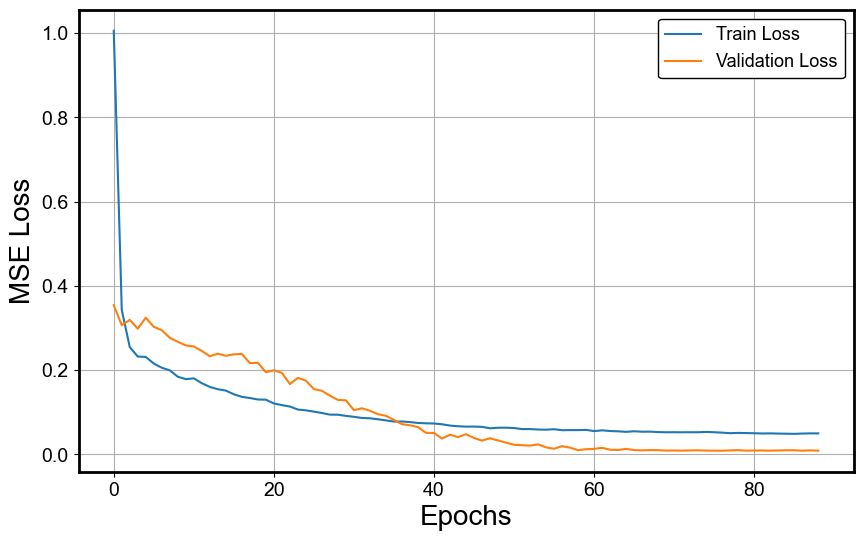

In [32]:
def plot_learning_curve(model):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

    ax.plot(model.history['loss'], label='Train Loss')
    ax.plot(model.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    plt.show()


plot_learning_curve(best_model_history)

# Comparing results

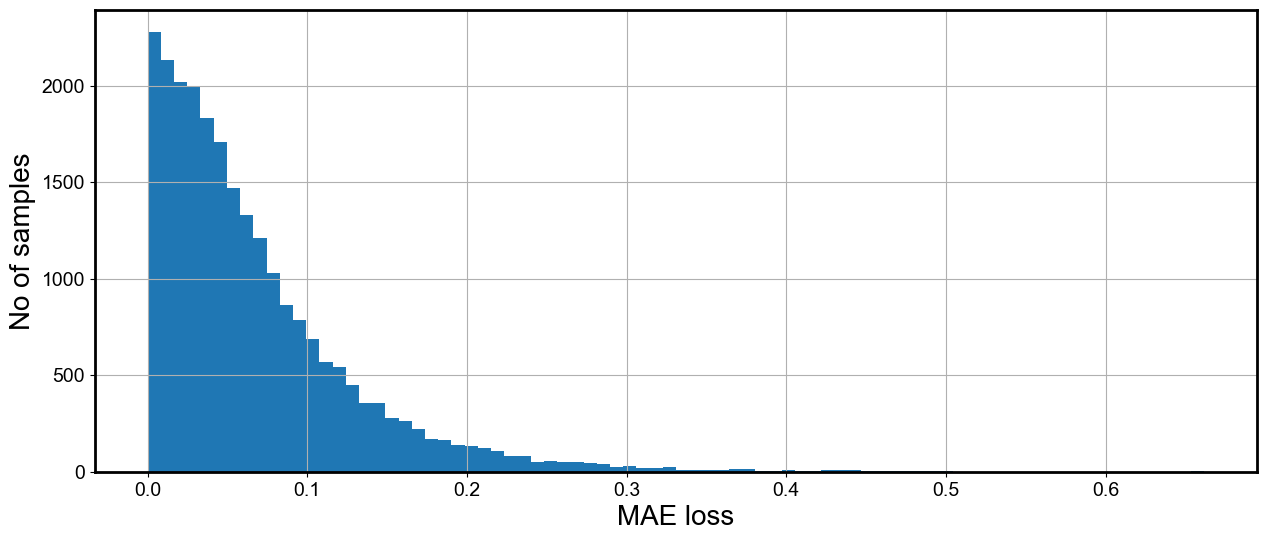

In [33]:
# Reshaping as if the dataset was one giant vector
df_pred = vanilla_reconstructed_model.predict(df_aux2)
df_pred = df_pred.reshape(-1,1)

df_ref = df_aux2.values.reshape(-1,1)

mae_loss = np.mean(np.abs(df_pred - df_ref), axis=1)

plt.hist(mae_loss, bins=80)
plt.xlabel("MAE loss")
plt.ylabel("No of samples")
plt.show()

In [34]:
logic_vector = pd.Series(mae_loss > 0.5)
logic_vector = logic_vector*1  # Converting from boolean to 0,1
logic_vector.name = 'logic'
# logic_vector

In [35]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


In [36]:
idx=0

df_sol = pd.concat([pd.Series(df_pred[:,idx]).rename('Prediction'),
           pd.Series(df_ref[:,idx]).rename('Reference'),
           logic_vector], axis=1)

df_sol.iplot()

# Visualizing latent space

In [37]:
enc = tf.keras.models.load_model("Vanilla_encoder")
enc.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder1_input (InputLayer)  [(None, 6)]               0         
_________________________________________________________________
encoder1 (Dense)             (None, 50)                350       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 102       
Total params: 652
Trainable params: 552
Non-trainable params: 100
_________________________________________________________________


In [38]:
latent_space = enc.predict(df_aux2.values)
latent_space.shape

(3986, 2)

In [39]:
latent_space

array([[ 2.3420637 ,  4.960984  ],
       [ 2.1709743 ,  5.3923817 ],
       [ 1.8373063 ,  5.5868287 ],
       ...,
       [ 0.6497537 ,  3.5558822 ],
       [-0.23217875,  5.5636888 ],
       [-1.0204725 ,  8.33733   ]], dtype=float32)

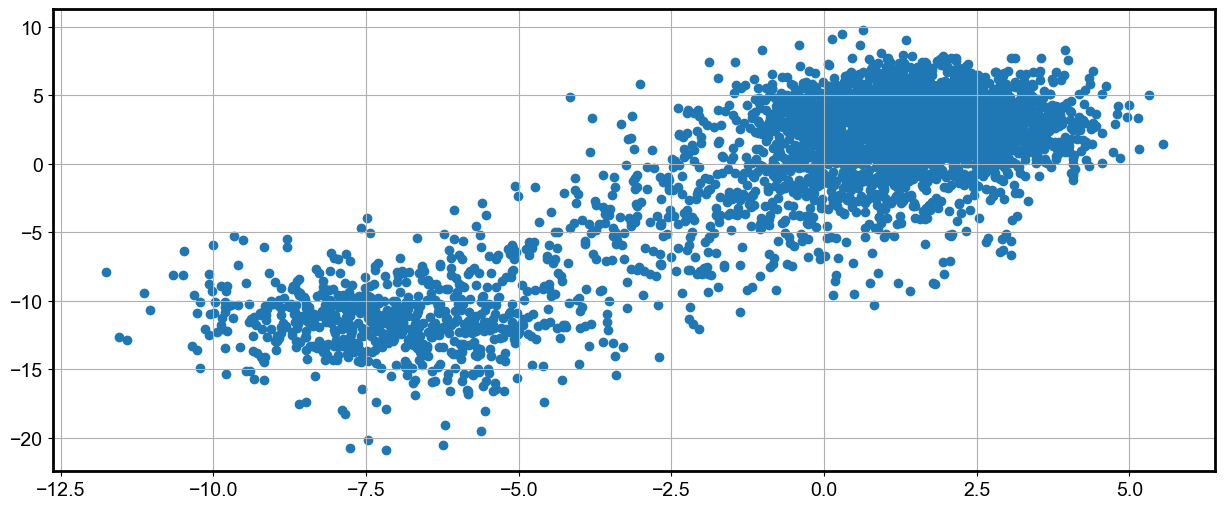

In [40]:
plt.scatter(latent_space[:,0],latent_space[:,1])